# Estimation de la Credit VaR avec la théorie des copules

Cheryl KOUADIO  
2025-03-14

# I. Extraction des probabilités de défauts

Au moyen d’une CreditVaR à 99 %, on cherche à évaluer le risque de
crédit sur un portefeuille composé de deux créances, issues du secteur
bancaire, de même notionnel 1000 EUR et de même maturité 4 ans.

La première est une obligation BNP senior de taux de recouvrement de
moyenne 60% et de volatilité 15%, et la seconde est une obligation
Société Générale junior (ou subordonnée) de taux de recouvrement de
moyenne 30% et de volatilité 25%. On suppose qu’il n’y a pas de
dépendance entre les taux de recouvrement.

On considère que les spreads de CDS de BNP et SG de maturité 4 ans sont
respectivement 100bp et 120bp et ceux de maturité 5ans, 120bp et 150bp.
Les CDS ont été évalués avec un taux de recouvrement égal à 40%. À
partir des spreads de CDS des deux entreprises pour diﬀérentes
maturités, extraire les probabilités de défaut implicites.

Pour extraire les probabilités de défauts, nous allons utilisé les CDS
étant plus liquides que les obligations. Les CDS sont des contrats
d’assurance contre le défaut d’une entreprise. Le spread de CDS est le
prix de cette assurance. Plus le spread est élevé, plus le marché estime
que l’entreprise est risquée. Le fair spread est donnée par :

$$
s* = (1-\delta) \times \lambda
$$

Avec $\delta$ le taux de recouvrement et $\lambda$ le hazard rate. Le
hazard rate est la probabilité de défaut de l’entreprise. On peut donc
isoler le hazard rate :

$$
\lambda = \frac{s*}{1-\delta}
$$

De ce fait, on peut calculer la probabilité de défaut donnée par : $$
PD = P(\tau < T) = 1 - e^{-\lambda \times T}
$$

car $\tau \sim Exp(\lambda)$

In [1]:
# Noms des entreprises
from pprint import pprint
import numpy as np
entreprises = ["BNP", "SG"]

def PD(T,spread,Recouvrement):
    lambda_ = spread / (1 - Recouvrement)
    PD = 1 - np.exp(-lambda_*T)
    return PD,lambda_

spread_4Y = np.array([100, 120]) / 10000 # 100 et 120 points de base
spread_5Y = np.array([120, 150]) / 10000 # 120 et 150 points de base
tx_recouvrement = 0.4

proba_defaut_quatre = np.zeros(len(spread_4Y))
proba_defaut_cinq = np.zeros(len(spread_5Y))

for i in range(len(spread_4Y)) :
    proba_defaut_quatre[i],_ = PD(spread=spread_4Y[i],T = 4,Recouvrement=0.4)
    print(_)
    proba_defaut_cinq[i],_ = PD(spread=spread_5Y[i],T = 5,Recouvrement=0.4)
    print(_)

# Création d'un dictionnaire pour stocker les probabilités de défaut
probabilites_defaut = {}

# Remplir le dictionnaire
for i, entreprise in enumerate(entreprises):
    probabilites_defaut[entreprise] = {
        "4 ans": round(proba_defaut_quatre[i]*100,4),
        "5 ans": round(proba_defaut_cinq[i]*100,4)
    }

# Afficher le dictionnaire
pprint(probabilites_defaut)

0.016666666666666666
0.02
0.02
0.025
{'BNP': {'4 ans': np.float64(6.4493), '5 ans': np.float64(9.5163)},
 'SG': {'4 ans': np.float64(7.6884), '5 ans': np.float64(11.7503)}}

Nous constatons que les probabilités de défaut pour les deux entreprises
pour une même maturité sont généralement plus élevés pour la Société
Générale que pour BNP Paribas. Cela est cohérent avec le type
d’obligation émise par les deux entreprises. En effet, une obligation
junior est plus risquée qu’une obligation senior.

# II. Caractérisation les distributions des taux de recouvrement de chacune des deux créances

Pour caractériser les distributions des taux de recouvrement, on va
utiliser la loi Beta(a,b). La loi Beta est une loi de probabilité
continue définie sur l’intervalle \[0, 1\]. Elle est souvent utilisée
pour modéliser des variables aléatoires qui prennent des valeurs dans un
intervalle borné en forme de U ce qui est le cas des taux de
recouvrement. L’expression de sa densité est donnée par :

$$
f(x) = \frac{x^{a-1} \times (1-x)^{b-1}}{B(a,b)} 1_{[0,1]}(x)
$$

Puisque nous possédons des taux de recouvrement de moyenne 60% et de
volatilité 15% pour la première créance et de moyenne 30% et de
volatilité 25% pour la seconde créance, nous allons utiliser la méthode
des moments pour déterminer les paramètres a et b de la loi Beta. De ce
fait, les paramètres sont calibrés de la manière suivante :

$$
a = \frac{\mu^2 \times (1-\mu)}{\sigma^2} - \mu; \quad b = \frac{\mu^2 \times (1-\mu)}{ \mu \sigma^2} - (1-\mu )
$$

La première est une obligation BNP senior de taux de recouvrement de
moyenne 60% et de volatilité 15%, et la seconde est une obligation
Société Générale junior (ou subordonnée) de taux de recouvrement de
moyenne 30% et de volatilité 25%.

### II.1. Caractérisation de la distribution des tx de recouvrement BNP

a_BNP =  5.8
b_BNP =  3.8666666666666676

Text(0.5, 1.0, 'Densité de probabilité du taux de recouvrement de BNP')

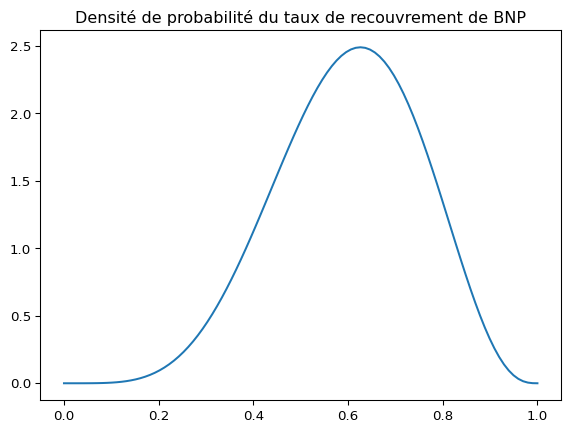

In [2]:
import numpy as np

tx_recouvrement_BNP = 0.6
vol_recouvrement_BNP = 0.15

def calibration_beta(mu,sigma):
    a = ((mu**2) * (1 - mu) / (sigma**2)) - mu
    b = ((mu**2) * (1 - mu)**2 / (mu*(sigma**2))) - (1-mu)
    return a,b

# def moment_beta(moyenne, variance):
#     alpha = (moyenne * (1 - moyenne) / variance**2 - 1) * moyenne
#     beta = (moyenne * (1 - moyenne) / variance**2 - 1) * (1 - moyenne)
#     return alpha, beta

a_BNP,b_BNP = calibration_beta(tx_recouvrement_BNP,vol_recouvrement_BNP)

print("a_BNP = ", a_BNP)
print("b_BNP = ", b_BNP)

# densité beta

from scipy.stats import beta
import matplotlib.pyplot as plt

x = np.linspace(0,1,100)
y_BNP = beta.pdf(x,a_BNP,b_BNP)

plt.plot(x,y_BNP)
plt.title("Densité de probabilité du taux de recouvrement de BNP")

Nous constatons que la distribution des taux de recouvrement de BNP est
légèrement asymétrique à droite. En effet, le paramètre a, contrôle la
concentration des valeurs proches de 1, est supérieur au paramètre b,
contrôle la concentration des valeurs proches de 0. De ce fait, la
distribution est asymétrique à gauche. Cependant que la majorité des
valeurs sont concentrées autour de la moyenne et il y a une **faible
probabilité de recouvrement très bas ou très élevé**.

### II.2. Caractérisation de la distribution des tx de recouvrement SG

a_SG =  0.708
b_SG =  1.652

Text(0.5, 1.0, 'Densité de probabilité du taux de recouvrement de BNP')

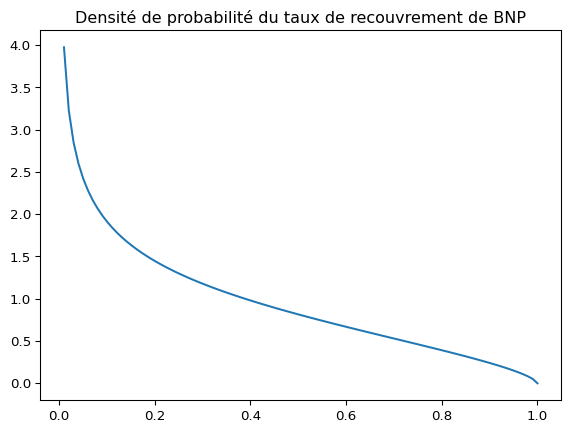

In [3]:
tx_recouvrement_SG = 0.3
vol_recouvrement_SG = 0.25


a_SG,b_SG = calibration_beta(tx_recouvrement_SG,vol_recouvrement_SG)

print("a_SG = ", a_SG)
print("b_SG = ", b_SG)

# densité beta
y_SG = beta.pdf(x,a_SG,b_SG)

plt.plot(x,y_SG)
plt.title("Densité de probabilité du taux de recouvrement de BNP")

En ce qui concerne la distribution des taux de recouvrement de la
Société Générale, nous constatons une asymétrie à gauche également.

La densité est **très asymétrique**, décroissant fortement à partir de
0. On constate une forte **concentration des valeurs proches de 0**
indique un **risque élevé de faible recouvrement**. La longue traîne
vers la droite signifie que, bien que des recouvrements plus élevés
soient possibles, ils sont peu probables.

## II.3. Comparaison des distributions

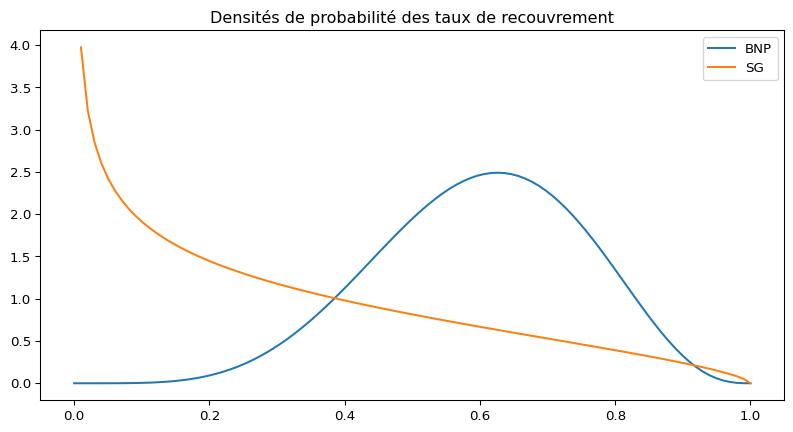

In [4]:
plt.figure(figsize=(10, 5))

plt.plot(x, y_BNP, label='BNP')
plt.plot(x, y_SG, label='SG')
plt.title("Densités de probabilité des taux de recouvrement")
plt.legend()
plt.show()

-   **BNP senior** : L’obligation senior bénéficie d’un **taux de
    recouvrement plus élevé et plus stable**, donc **moins risqué**.
-   **SG junior** : L’obligation junior a une **probabilité élevée d’un
    recouvrement très faible**, ce qui reflète un **risque plus
    important**.

Cela est cohérent avec la catégorisation des obligations. Dans la
hiérarchie des dettes, une obligation peut être classée comme senior ou
junior (subordonnée) en fonction de la priorité de remboursement en cas
de faillite de l’émetteur. Cette distinction est essentielle pour
évaluer le risque de crédit et le taux de recouvrement attendu. Une
obligation classée senior est moins risquée qu’une obligation junior,
car elle est remboursée en premier en cas de défaut de l’émetteur,
cependant le rendement attendu est moins élevé. Par conséquent, les
obligations senior ont un taux de recouvrement plus élevé et plus stable
que les obligations junior.

# III. Caractérisation des lois de défauts

Pour caractériser les lois de défaut, nous avons besoin de prendre en
compte la structure de dépendance en plus des lois marginales présentées
dans la section I. Pour ce faire, nous devons utiliser un produit dnt le
prix dépendant de la dépendance entre les défauts des deux entreprises.
Dans notre cas, nous utiliserons le prix des actions des deux
entreprises pour déterminer la dépendance entre les défauts.

## III.1. Analyse exploratoire univariée des données actions de ces deux entreprises.

En observant le prix des actions BNP et SG, nous constatons que les
actions BNP ont un prix plus élevés que les actions SG. Cela est
cohérent avec la capitalisation boursière des deux entreprises. De plus,
nous constatons que les rendements de BNP sont semblables à ceux de SG.
Cela est cohérent avec le fait que les deux entreprises sont des banques
françaises et sont donc exposées aux mêmes risques macroéconomiques.
Néanmoins, les actions de BNP présentent une volatilité légèrement plus
élevé que celles de SG.

In [5]:
# read data.txt
import pandas as pd
import matplotlib.pyplot as plt
data = pd.read_csv('data.txt', sep="\t")
data.head()

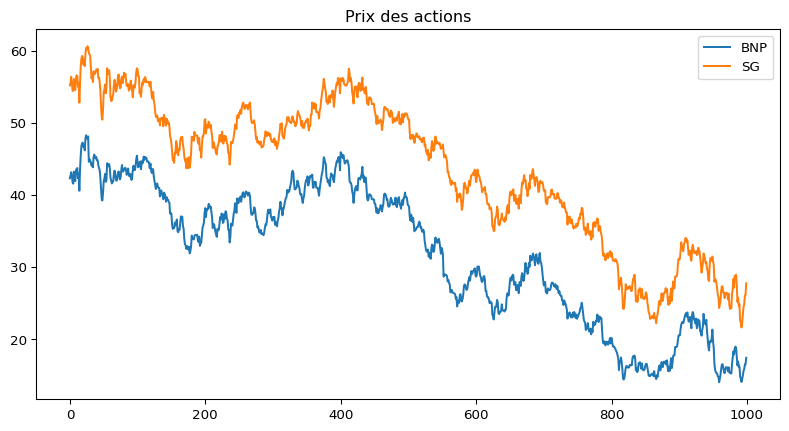

In [6]:
plt.figure(figsize=(10, 5))
plt.plot(data['BNP'], label='BNP')
plt.plot(data['SG'], label='SG')
plt.title("Prix des actions")
plt.legend()
plt.show()

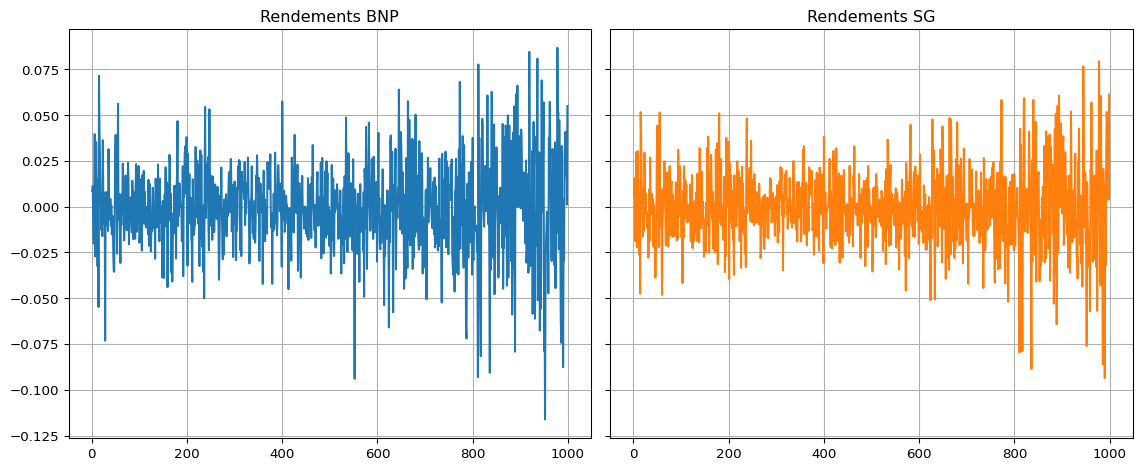

In [7]:
returns = pd.DataFrame()
returns["BNP"] = data["BNP"].pct_change().dropna()
returns["SG"] = data["SG"].pct_change().dropna()

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Premier sous-graphique : Rendements BNP
axes[0].plot(returns["BNP"], color='tab:blue')
axes[0].set_title("Rendements BNP")
axes[0].grid(True)

# Deuxième sous-graphique : Rendements SG
axes[1].plot(returns["SG"], color='tab:orange')
axes[1].set_title("Rendements SG")
axes[1].grid(True)

# Ajustement automatique pour éviter les chevauchements
plt.tight_layout()

# Affichage
plt.show()

In [8]:
returns.describe()

## III.2. Modélisation des distributions univariées des facteurs de risques

Dans le cadre des prix des actions, le seul facteur de risque est le
rendement. Nous allons donc modéliser les rendements des actions de BNP
et SG par des lois normales, lois student, skew student, et Normal
Inverse Gaussian afin de déterminer la loi qui s’ajuste le mieux aux
données.

### III.2.1. Modélisation des rendements de BNP

En ce qui concerne les rendements de BNP, nous constatons que les lois
de student et normal inverse gaussian sont les plus adaptées pour
modéliser les rendements de BNP. En effet, lorsqu’on compare les QQ-plot
des rendements de BNP avec les lois normales, student, skew student et
normal inverse gaussian, on constate que les quantiles empiriques des
rendements de BNP sont plus proches des quantiles théoriques des lois
student et normal inverse gaussian. De plus, les densités ajustées
semblent également mieux coller aux données.

Si l’on devait choisir une loi pour modéliser les rendements de BNP,
nous choisirions la loi normal inverse gaussian. En effet, bien qu’elle
soit plus complexe à modéliser, elle permet d’avoir un p-value, au test
de Kolmogorov-Smirnov, plus élevé que la loi student. Cela signifie que
la loi normal inverse gaussian est plus adaptée pour modéliser les
rendements de BNP.

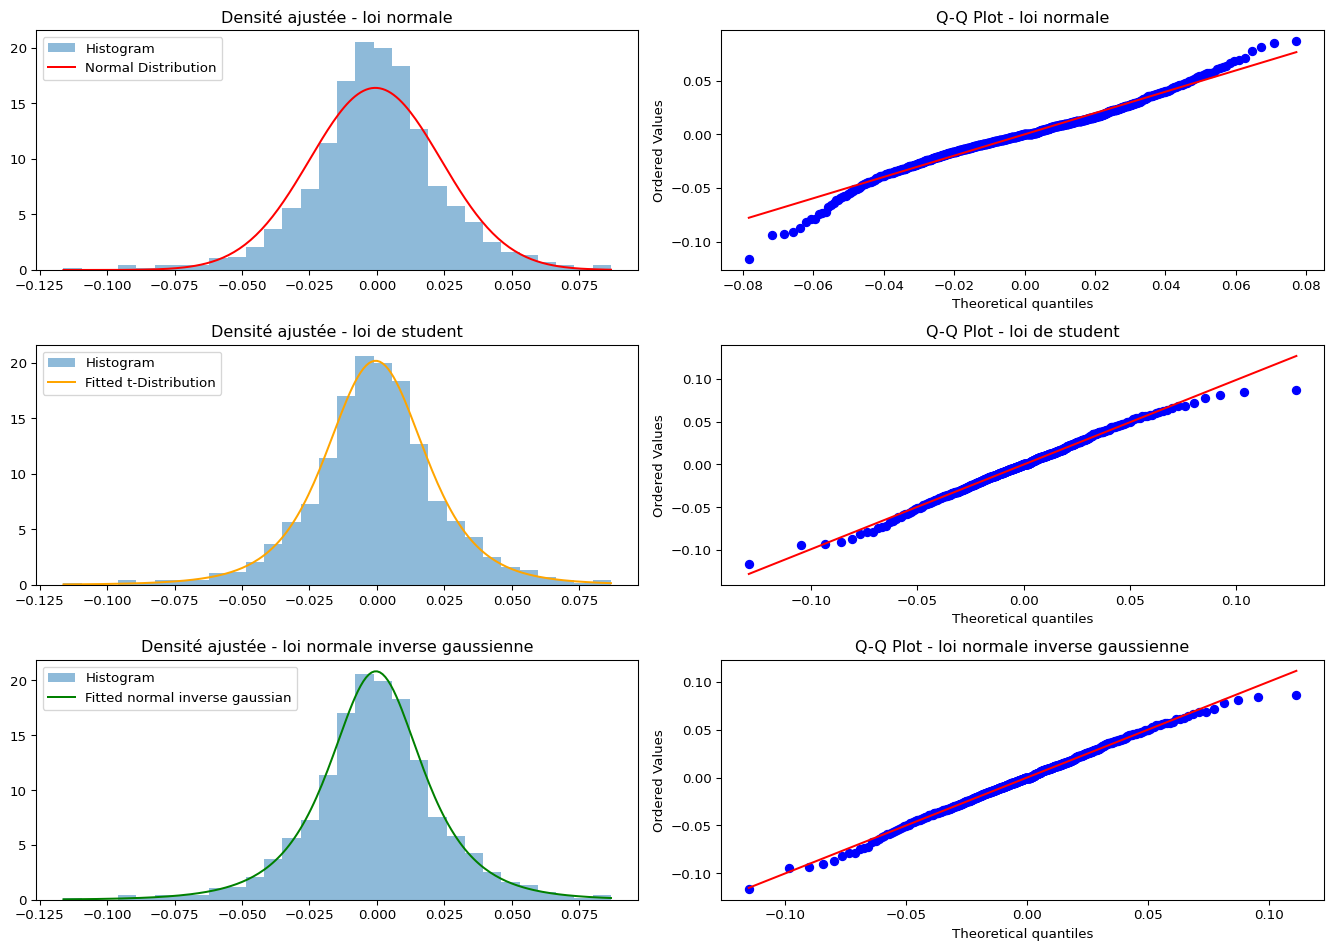

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

# Simulation de données pour l'exemple (remplace par tes données réelles)
data = returns["BNP"]

# Création de la figure et des axes pour 4 subplots (2 lignes, 2 colonnes)
fig, axs = plt.subplots(3, 2, figsize=(14, 10))

######################## Loi normale ########################
params_norm = stats.norm.fit(data)

# Histogramme avec densité théorique de la loi normale (subplot 0,0)
xs = np.linspace(np.min(data), np.max(data), 200)
axs[0, 0].hist(data, bins=30, density=True, alpha=0.5, label="Histogram")
axs[0, 0].plot(xs, stats.norm.pdf(xs, *params_norm), label='Normal Distribution', color='red')
axs[0, 0].set_title('Densité ajustée - loi normale')
axs[0, 0].legend(loc='upper left')

# Q-Q plot (subplot 0,1)
stats.probplot(data, dist="norm",sparams=(params_norm), plot=axs[0, 1])
axs[0, 1].set_title('Q-Q Plot - loi normale')

######################## Loi de student ########################

# Estimation des paramètres de la distribution de Student pour vos données.
params_std= stats.t.fit(data)

# Histogramme avec densité théorique de la loi de Student.
xs = np.linspace(np.min(data), np.max(data), 200)
axs[1, 0].hist(data, bins=30, density=True, alpha=0.5, label="Histogram")
axs[1, 0].plot(xs, stats.t.pdf(xs, *params_std), label='Fitted t-Distribution',color='orange')
axs[1, 0].set_title('Densité ajustée - loi de student')
axs[1, 0].legend(loc='upper left')

# Q-Q plot avec une loi de Student.
stats.probplot(data, dist="t", sparams=(params_std), plot=axs[1, 1])
axs[1, 1].set_title('Q-Q Plot - loi de student')

######################## Loi de Normal Inverse Gaussian ########################
params_nig = stats.norminvgauss.fit(data)

axs[2, 0].hist(data, bins=30, density=True, alpha=0.5, label="Histogram")
axs[2, 0].plot(xs, stats.norminvgauss.pdf(xs, *params_nig), label='Fitted normal inverse gaussian',color='green')
axs[2, 0].set_title('Densité ajustée - loi normale inverse gaussienne')
axs[2, 0].legend(loc='upper left')

# Q-Q plot avec une loi de NIG.
stats.probplot(data, dist="norminvgauss", sparams=(params_nig), plot=axs[2, 1])
axs[2, 1].set_title('Q-Q Plot - loi normale inverse gaussienne')

plt.tight_layout()

# Affichage des graphiques
plt.show()

U = pd.DataFrame(index=returns.index, columns=returns.columns)

U['BNP'] = stats.norminvgauss.cdf(data,*params_nig)

In [10]:
print(params_norm)
print(params_std)
print(params_nig)

(np.float64(-0.0005897932128196069), np.float64(0.024327449407557697))
(np.float64(4.605552436800593), np.float64(-0.00046153919290846087), np.float64(0.018734588738427177))
(np.float64(1.114374971099747), np.float64(-0.01637147555477723), np.float64(-0.00021011775496697913), np.float64(0.025828797181227353))

In [11]:
######## Test de kolmogorov-smirnov ########

ks_stat_norm, ks_p_value_norm = stats.kstest(data, 'norm', args=(params_norm))
ks_stat_std, ks_p_value_std = stats.kstest(data, 't', args=(params_std))
ks_stat_nig, ks_p_value_nig = stats.kstest(data, 'norminvgauss', args=(params_nig))

res = pd.DataFrame({
                "Statistic": [ks_stat_norm, ks_stat_std, ks_stat_nig],
                "p-value": [ks_p_value_norm, ks_p_value_std, ks_p_value_nig]
            }, index=["Normal", "Student","Normal Inverse Gaussian"])

print("="*50)
print("Test de Kolmogorov-Smirnov")
print("="*50)
print(res)
print("="*50)

Test de Kolmogorov-Smirnov
                         Statistic   p-value
Normal                    0.051878  0.008908
Student                   0.027225  0.441752
Normal Inverse Gaussian   0.026466  0.477953

### III.2.1. Modélisation des rendements de SG

Comme les rendements de BNP, les rendements de SG sont mieux modélisés
par les lois student et normal inverse gaussian.

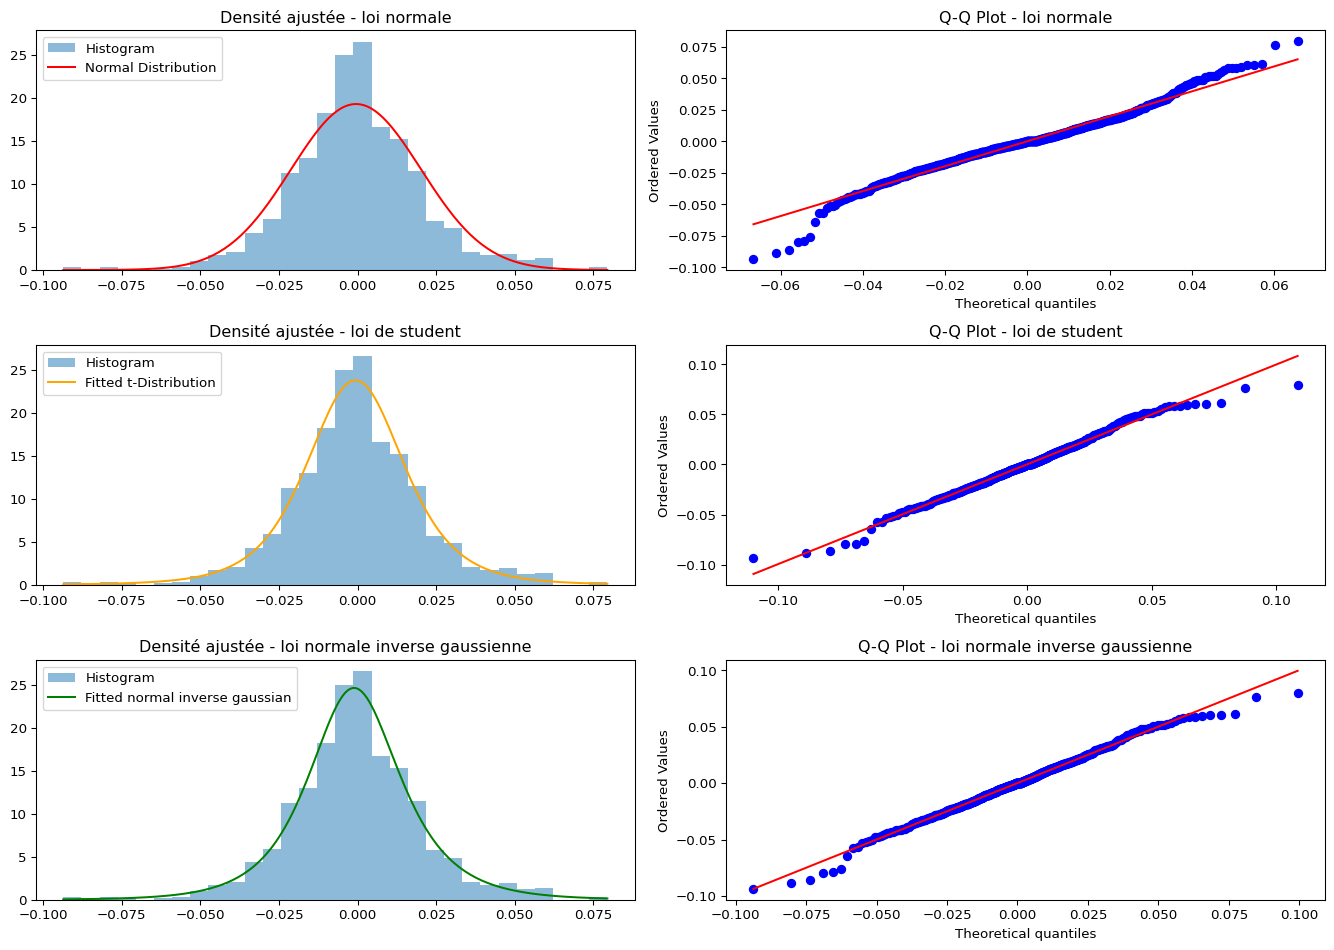

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

# Simulation de données pour l'exemple (remplace par tes données réelles)
data = returns["SG"]

# Création de la figure et des axes pour 4 subplots (2 lignes, 2 colonnes)
fig, axs = plt.subplots(3, 2, figsize=(14, 10))

######################## Loi normale ########################
params_norm = stats.norm.fit(data)

# Histogramme avec densité théorique de la loi normale (subplot 0,0)
xs = np.linspace(np.min(data), np.max(data), 200)
axs[0, 0].hist(data, bins=30, density=True, alpha=0.5, label="Histogram")
axs[0, 0].plot(xs, stats.norm.pdf(xs, *params_norm), label='Normal Distribution', color='red')
axs[0, 0].set_title('Densité ajustée - loi normale')
axs[0, 0].legend(loc='upper left')

# Q-Q plot (subplot 0,1)
stats.probplot(data, dist="norm",sparams=(params_norm), plot=axs[0, 1])
axs[0, 1].set_title('Q-Q Plot - loi normale')

######################## Loi de student ########################

# Estimation des paramètres de la distribution de Student pour vos données.
params_std= stats.t.fit(data)

# Histogramme avec densité théorique de la loi de Student.
xs = np.linspace(np.min(data), np.max(data), 200)
axs[1, 0].hist(data, bins=30, density=True, alpha=0.5, label="Histogram")
axs[1, 0].plot(xs, stats.t.pdf(xs, *params_std), label='Fitted t-Distribution',color='orange')
axs[1, 0].set_title('Densité ajustée - loi de student')
axs[1, 0].legend(loc='upper left')

# Q-Q plot avec une loi de Student.
stats.probplot(data, dist="t", sparams=(params_std), plot=axs[1, 1])
axs[1, 1].set_title('Q-Q Plot - loi de student')

######################## Loi de Normal Inverse Gaussian ########################
params_nig = stats.norminvgauss.fit(data)

axs[2, 0].hist(data, bins=30, density=True, alpha=0.5, label="Histogram")
axs[2, 0].plot(xs, stats.norminvgauss.pdf(xs, *params_nig), label='Fitted normal inverse gaussian',color='green')
axs[2, 0].set_title('Densité ajustée - loi normale inverse gaussienne')
axs[2, 0].legend(loc='upper left')

# Q-Q plot avec une loi de NIG.
stats.probplot(data, dist="norminvgauss", sparams=(params_nig), plot=axs[2, 1])
axs[2, 1].set_title('Q-Q Plot - loi normale inverse gaussienne')

plt.tight_layout()

# Affichage des graphiques
plt.show()

U['SG'] = stats.norminvgauss.cdf(data,*params_nig)

U = U.to_numpy()

In [13]:
######## Test de kolmogorov-smirnov ########

ks_stat_norm, ks_p_value_norm = stats.kstest(data, 'norm', args=(params_norm))
ks_stat_std, ks_p_value_std = stats.kstest(data, 't', args=(params_std))
ks_stat_nig, ks_p_value_nig = stats.kstest(data, 'norminvgauss', args=(params_nig))

res = pd.DataFrame({
                "Statistic": [ks_stat_norm, ks_stat_std, ks_stat_nig],
                "p-value": [ks_p_value_norm, ks_p_value_std, ks_p_value_nig]
            }, index=["Normal", "Student","Normal Inverse Gaussian"])

print("="*50)
print("Test de Kolmogorov-Smirnov")
print("="*50)
print(res)
print("="*50)

Test de Kolmogorov-Smirnov
                         Statistic   p-value
Normal                    0.047345  0.021967
Student                   0.025635  0.519206
Normal Inverse Gaussian   0.022462  0.685866

## III.3. Etude de la structure de dépendance

Pour étudier la structure de dépendance entre les défauts des deux
entreprises, nous pouvons tester la corrélation entre les rendements des
actions de BNP et SG. Nous pouvons visualiser le dependogramme pour voir
la structure de dépendance entre les deux entreprises.

In [14]:
# Tableax avec tx de pearson, spearman et kendall

from scipy.stats import pearsonr, spearmanr, kendalltau

pearson = pearsonr(returns["BNP"], returns["SG"])
spearman = spearmanr(returns["BNP"], returns["SG"])
kendall = kendalltau(returns["BNP"], returns["SG"])

tableau_correlation = pd.DataFrame({
    "Pearson": pearson,
    "Spearman": spearman,
    "Kendall": kendall
}, index=["Coefficient", "p-value"])

tableau_correlation

En analysant la corrélation entre les rendements de BNP et SG, nous
constatons qu’il y a une corrélation positive significative peu importe
le test de corrélation effectué. La corrélation de spearman et de
pearson indique qu’il y a une liaison monotone et linéaire forte d’au
moins 84% entre les rendements des deux entreprises. En ce qui concerne
le taux de kendall, nous constatons une corrélation positive
significative de 67% environ. Cela signifie que les rendements des
actions de BNP et SG sont positivement corrélés.

/! Attention la corrélation de pearson n’est pas une mesure de
concordance contrairement au coefficient de spearman. Dans notre cas, il
indique une corrélation linéaire forte.

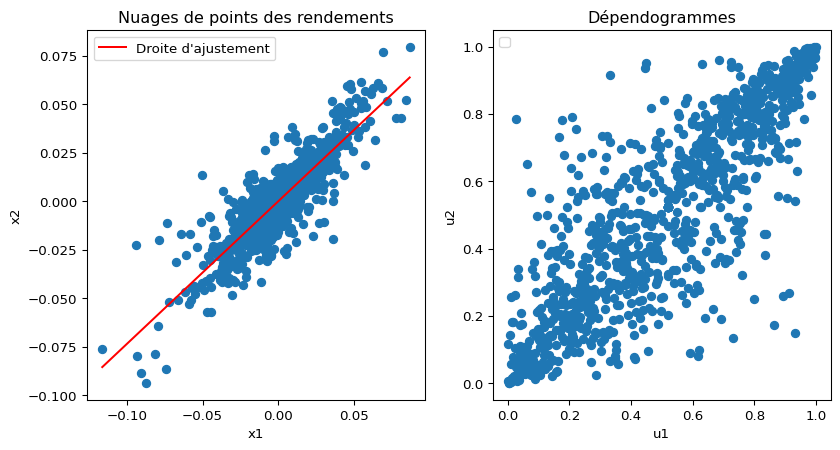

In [15]:
# Dependogramme
# Posons x1, u1 = BNP et x2, u2 = SG
import warnings
from scipy.stats import rankdata

warnings.filterwarnings("ignore")

# 1. Transformation en pseudo-observations
def pseudo_observations(X):
    """Transforme les données en pseudo-observations U dans [0,1]."""
    n, d = X.shape
    U = np.zeros((n, d))
    for j in range(d):
        U[:, j] = rankdata(X[:, j]) / (n + 1)  # Pour éviter les 1 stricts
    return U

X = returns.to_numpy()
u_obs = pseudo_observations(X)


plt.figure(figsize=(10, 5))
plt.subplot(1,2,1) # 1 ligne, 2 colonnes, premier graphique

# nuages de points des données BNP et SG
plt.scatter(returns["BNP"], returns["SG"], cmap="viridis")
# Ajout la droite qui s'ajuste aux données
plt.plot(np.unique(returns["BNP"]), np.poly1d(np.polyfit(returns["BNP"], returns["SG"], 1))(np.unique(returns["BNP"])), color="red", label="Droite d'ajustement")
plt.title("Nuages de points des rendements")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.grid(False)

plt.subplot(1,2,2)
plt.scatter(u_obs[:,0], u_obs[:,1])
plt.title("Dépendogrammes")
plt.xlabel("u1")
plt.ylabel("u2")
plt.legend()
plt.grid(False)
plt.show()

En observant le dépendogramme, nous constatons la même dépendance
positive entre les deux entreprises. Cela signifie que si l’une des
entreprises fait défaut, l’autre a plus de chance de faire défaut
également. Cela est cohérent avec la corrélation positive observée entre
les rendements des actions de BNP et SG.

De plus, en observant le dépendogramme, il semble avoir des dépendances
à gauche et à droite entre les deux entreprises. Nous allons tout de
même tester un éventail de copules afin de vérifier laquelle des copules
est la plus adaptée à notre cas : - Copules elliptiques : gaussienne,
Student. - Copules archimédiennes : Clayton, Gumbel, Frank.

Il faudrait au préalable estimer les paramètres des copules
archimédiennes et elliptiques pour déterminer laquelle des copules est
la plus adaptée à notre cas. Précedemment, nous avons estimé les
paramètres des lois marginales des rendements de BNP et SG. Nous allons
utiliser ces paramètres pour estimer les paramètres des copules. Nous
allons utiliser ces paramètres pour la modélisation des différentes
copules.

In [16]:
from scipy.optimize import minimize
from statsmodels.distributions.copula.api import (
    GaussianCopula, StudentTCopula, ClaytonCopula, GumbelCopula, FrankCopula
)

def get_copula(copula_type, params):
    if copula_type == "gaussian":
        rho = params[0]
        return GaussianCopula(corr=np.array([[1, rho], [rho, 1]]))
    elif copula_type == "student":
        rho, nu = params
        return StudentTCopula(corr=np.array([[1, rho], [rho, 1]]), df=nu)
    elif copula_type == "clayton":
        theta = params[0]
        return ClaytonCopula(theta=theta)
    elif copula_type == "gumbel":
        theta = params[0]
        return GumbelCopula(theta=theta)
    elif copula_type == "frank":
        theta = params[0]
        return FrankCopula(theta=theta)
    else:
        raise ValueError(f"Copula type {copula_type} not supported")


# Log-vraisemblance négative pour estimation MLE
def negative_log_likelihood(params, U, copula_type):
    copula = get_copula(copula_type, params)
    log_likelihood = copula.logpdf(U)
    return -np.sum(log_likelihood)

# Ajustement de la copule (MLE)
def fit_copula(U, copula_type):
    if copula_type in ["gaussian", "gumbel", "clayton", "frank"]:
        if copula_type=="gaussian":
            x0 = [0.6]
        else:
            x0 = [3]
        bounds = [(1e-5, 10)] if copula_type != "gaussian" else [(-0.99, 0.99)]
    elif copula_type == "student":
        x0 = [0.6, 3]  # rho et df
        bounds = [(-0.99, 0.99), (2, 30)]

    result = minimize(negative_log_likelihood, x0, args=(U, copula_type), bounds=bounds, method='Nelder-Mead')

    if not result.success:
        raise RuntimeError(f"MLE failed for {copula_type} copula: {result.message}")

    return result.x

## III.4. Modélisation la structure de dépendance au moyen des copules paramétriques

### III.4.1 Copule gaussienne

#### III.4.1.a. Estimation des paramètres de la copule gaussienne

Dans le cadre de la copule gaussienne, il nous faut la matrice de
variance qui est donnée par :

$$
\begin{pmatrix}
1 & \rho \\
\rho & 1 
\end{pmatrix}
$$

Dans notre cas, le seul paramètre à estimer est le coefficient de
corrélation de pearson. Nous allons donc estimer le coefficient de
corrélation de pearson entre les rendements des actions de BNP et SG.

In [17]:
rho = fit_copula(u_obs, "gaussian")[0]

mat= np.array([[1, rho], [rho, 1]])
mat

array([[1.        , 0.86097656],
       [0.86097656, 1.        ]])

#### III.4.1.b. Simulation de la copule gaussienne

Pour simuler la copule gaussienne, nous allons utiliser la méthode de
distribution puisque la loi est facile à implémenter.

In [18]:
# # Simuler réalisation W suivant une loi normale centrée multivariée
# import scipy.stats as stats

# np.random.seed(0)
# n = 1000
# W = np.random.multivariate_normal([0, 0], mat, n)

# # Calculer U1 et U2
# U = np.zeros((n, 2))

# for i in range(n):
#     U[i,0] = stats.norm.cdf(W[i,0])
#     U[i,1] = stats.norm.cdf(W[i,1])


n = u_obs.shape[0]
_ = GaussianCopula(corr = rho).rvs(n)
u_est = pseudo_observations(_)

#### III.4.1.c. Test d’ajustement

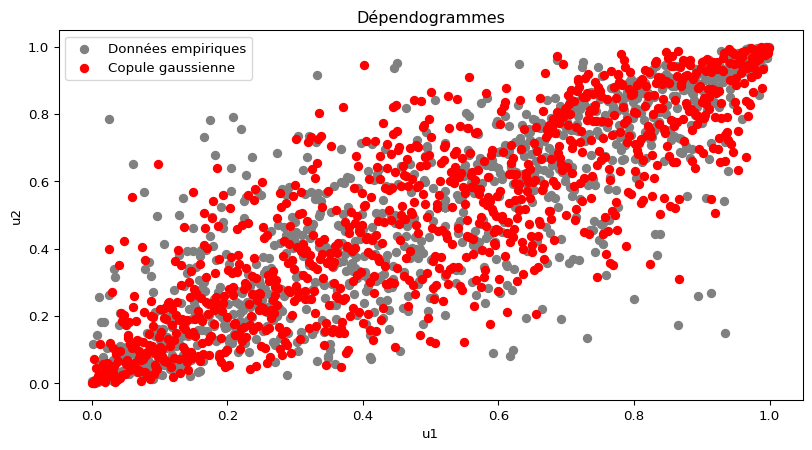

In [19]:
plt.figure(figsize=(10, 5))
plt.scatter(u_obs[:,0], u_obs[:,1], label = "Données empiriques", color = "grey")
plt.scatter(u_est[:,0], u_est[:,1], label = "Copule gaussienne", color = "red")
plt.title("Dépendogrammes")
plt.xlabel("u1")
plt.ylabel("u2")
plt.legend()
plt.grid(False)
plt.show()

(999,) (999,)

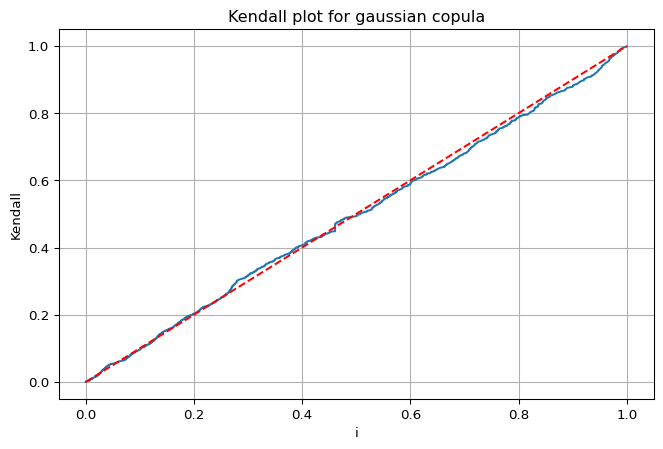

In [20]:
# Kendall plot
import numpy as np

def calculer_Hi_vect(U):
    n=len(U)
    H = np.zeros(n, dtype=int)
    # Comparaison de chaque paire une seule fois
    for i in range(n):
        # Créer des masques booléens pour les conditions
        cond1 = U[:, 0] <= U[i, 0]  # u_{1,j} <= u_{1,i}
        cond2 = U[:, 1] <= U[i, 1]  # u_{2,j} <= u_{2,i}

        # Appliquer les conditions et exclure le cas où i == j
        H[i] = (np.sum(np.logical_and(cond1, cond2)) - 1)

    return H/(len(U)-1)


def kendall_plot(U,S=1000,copula="gaussian",rho=None,nu=None,theta=None):

    H_i = calculer_Hi_vect(U)
    n = len(U)

    H_means = np.zeros((S, n)) # S lignes et n colonnes
    for s in range(S):
        if copula == 'gaussian':
            X_ = GaussianCopula(corr=rho).rvs(n)
        elif copula == 'student':
            X_ = StudentTCopula(df = nu, corr = rho).rvs(n)
        elif copula == "gumbel":
            X_= GumbelCopula(theta = theta).rvs(n)
        elif copula == "clayton":
            X_= ClaytonCopula(theta = theta).rvs(n)
        elif copula == "frank":
            X_= FrankCopula(theta = theta).rvs(n)
        U_=pseudo_observations(X_)
        H_means[s] = np.sort(calculer_Hi_vect(U_))

    H_mean = np.mean(H_means, axis=0) # axis=0 pour moyenne par colonne

    x,y = np.sort(H_i), np.sort(H_mean)
    print(x.shape, y.shape)

    plt.figure(figsize=(8, 5))
    plt.plot(x, y)
    plt.plot([0, 1], [0, 1], color="red", linestyle="--")
    plt.title(f"Kendall plot for {copula} copula")
    plt.xlabel("i")
    plt.ylabel("Kendall")
    plt.grid(True)
    plt.show()

S=1000
kendall_plot(u_obs,S,copula="gaussian",rho=rho)

#### III.4.1.d. Test d’adéquation

In [21]:
# Copule empirique Cn(u)
def empirical_copula_cdf(U, u):
    """Calcule la copule empirique Cn(u)."""
    return np.mean(np.all(U <= u, axis=1))

# Statistique de Cramér-von Mises
def cramer_von_mises_stat(U, copula):
    """Calcule la statistique de test Tn."""
    n = len(U)
    Tn = 0.0
    for i in range(n):
        u_i = U[i]
        Cn = empirical_copula_cdf(U, u_i)  # Copule empirique Cn(u_i)
        C_theta = copula.cdf([u_i])  # Copule théorique estimée Cθ(u_i)
        Tn += (Cn - C_theta) ** 2
    return Tn

# Test d’adéquation complet avec bootstrap paramétrique
def adequation_test(X, copula_type="gaussian", M=500):
    """
    Test d'adéquation de Genest & Rémillard (2008) pour une copule avec
    statistique de Cramér-von Mises et bootstrap paramétrique.
    """
    # Pseudo-observations
    U = pseudo_observations(X)
    n = len(U)

    # Estimation MLE de la copule sur les données
    params = fit_copula(U, copula_type)
    copula = get_copula(copula_type, params)

    # Calcul de la statistique observée Tn
    T_obs = cramer_von_mises_stat(U, copula)

    # Bootstrap paramétrique
    T_boot = []
    for _ in range(M):
        # 1. Simulation d’un échantillon sous la copule ajustée
        U_boot = copula.rvs(n)

        # 2. Ré-estimation de la copule sur U_boot
        params_boot = fit_copula(U_boot, copula_type)
        copula_boot = get_copula(copula_type, params_boot)

        # 3. Calcul de Tn pour cet échantillon bootstrap
        T_boot.append(cramer_von_mises_stat(U_boot, copula_boot))

    # Calcul de la p-value (proportion des T_boot supérieurs à T_obs)
    p_value = np.mean(np.array(T_boot) >= T_obs)

    return {
        "copula_type": copula_type,
        "params": params,
        "T_obs": T_obs,
        "p_value": p_value
    }

from pprint import pprint
result_gaussian = adequation_test(X, copula_type="gaussian")
pprint(result_gaussian)

{'T_obs': np.float64(0.054564311624880506),
 'copula_type': 'gaussian',
 'p_value': np.float64(0.886),
 'params': array([0.86097656])}

### III.4.2 Copule de student

#### III.4.2.a. Estimation des paramètres de la copule student

In [22]:
rho,nu = fit_copula(u_obs, "student")

print("rho = ", rho)
print("nu = ", nu)

rho =  0.8496143388748167
nu =  2.0

#### III.4.2.b. Simulation de la copule de student

In [23]:
n = u_obs.shape[0]
_ = StudentTCopula(corr = rho, df=nu).rvs(n)
u_est = pseudo_observations(_)

#### III.4.2.c. Test d’ajustement

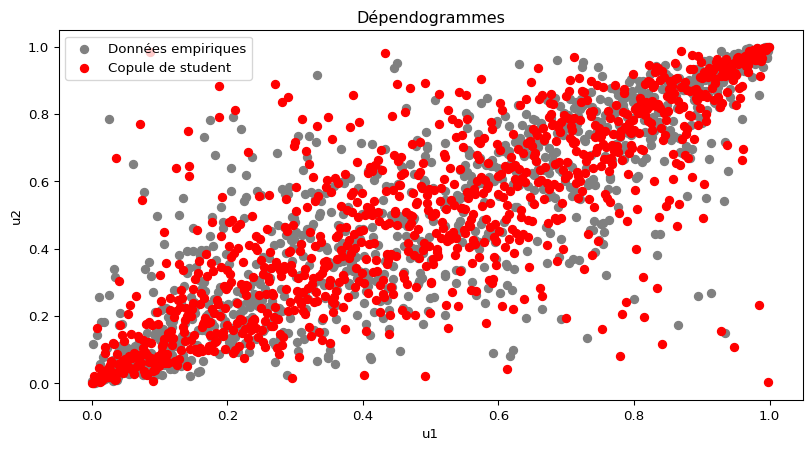

In [24]:
plt.figure(figsize=(10, 5))
plt.scatter(u_obs[:,0], u_obs[:,1], label = "Données empiriques", color = "grey")
plt.scatter(u_est[:,0], u_est[:,1], label = "Copule de student", color = "red")
plt.title("Dépendogrammes")
plt.xlabel("u1")
plt.ylabel("u2")
plt.legend()
plt.grid(False)
plt.show()

(999,) (999,)

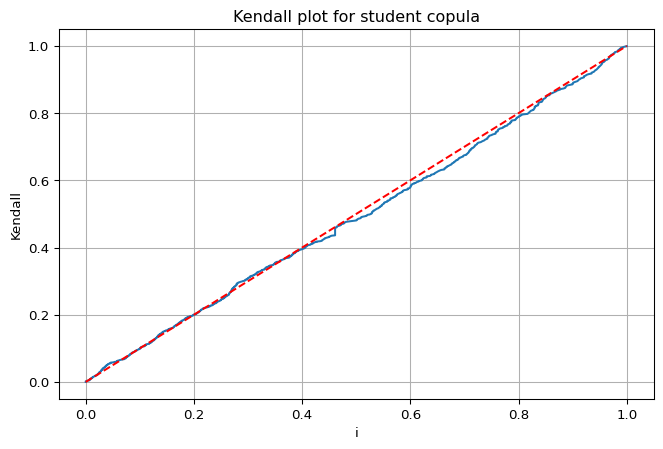

In [25]:
kendall_plot(u_obs,S,copula="student",rho=rho,nu=nu)

#### III.4.2.d. Test d’adéquation

### III.4.3 Copule de clayton

#### III.4.3.a. Estimation des paramètres de la copule clayton

In [26]:
theta = fit_copula(u_obs, "clayton")[0]

print("theta = ", theta)

theta =  2.4768310546874988

#### III.4.3.b. Simulation de la copule de clayton

In [27]:
n = u_obs.shape[0]
_ = ClaytonCopula(theta= theta).rvs(n)
u_est = pseudo_observations(_)

#### III.4.3.c. Test d’ajustement

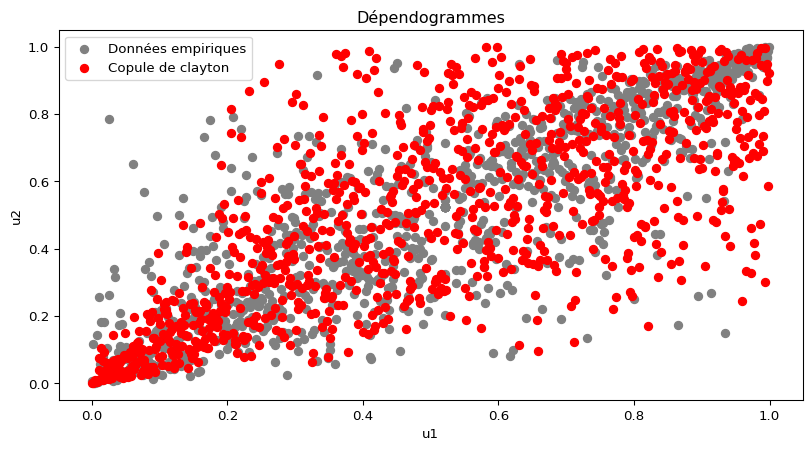

In [28]:
plt.figure(figsize=(10, 5))
plt.scatter(u_obs[:,0], u_obs[:,1], label = "Données empiriques", color = "grey")
plt.scatter(u_est[:,0], u_est[:,1], label = "Copule de clayton", color = "red")
plt.title("Dépendogrammes")
plt.xlabel("u1")
plt.ylabel("u2")
plt.legend()
plt.grid(False)
plt.show()

(999,) (999,)

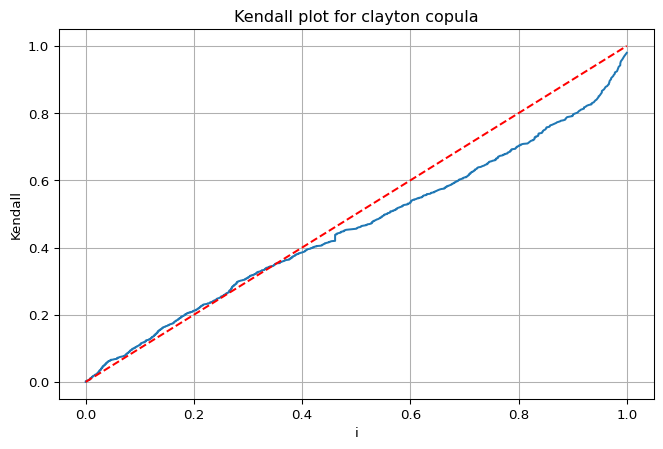

In [29]:
S=1000
kendall_plot(u_obs,S,copula="clayton",theta=theta)

#### III.4.3.d. Test d’adéquation

In [30]:
from pprint import pprint
result_clayton= adequation_test(X, copula_type="clayton") 
pprint(result_clayton)

{'T_obs': array([0.86477661]),
 'copula_type': 'clayton',
 'p_value': np.float64(0.004),
 'params': array([2.47683105])}

### III.4.4 Copule de gumbel

#### III.4.4.a. Estimation des paramètres de la copule gumbel

In [31]:
theta = fit_copula(u_obs, "gumbel")[0]

print("theta = ", theta)

theta =  2.9939208984374996

#### III.4.4.b. Simulation de la copule de clayton

In [32]:
n = u_obs.shape[0]
_ = GumbelCopula(theta= theta).rvs(n)
u_est = pseudo_observations(_)

#### III.4.4.c. Test d’ajustement

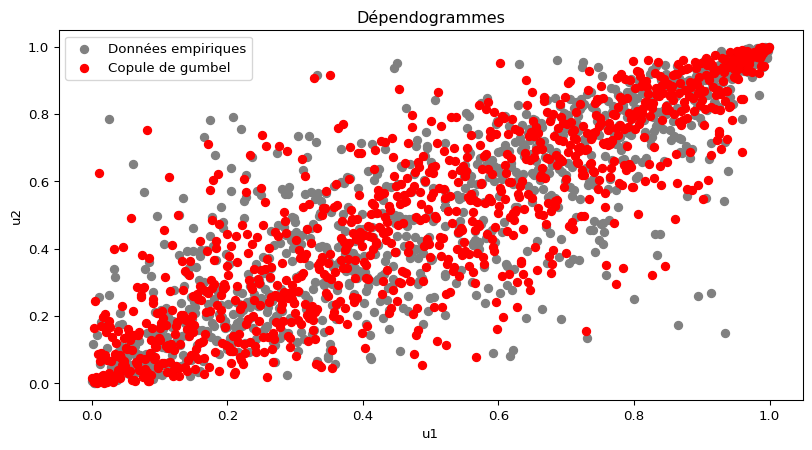

In [33]:
plt.figure(figsize=(10, 5))
plt.scatter(u_obs[:,0], u_obs[:,1], label = "Données empiriques", color = "grey")
plt.scatter(u_est[:,0], u_est[:,1], label = "Copule de gumbel", color = "red")
plt.title("Dépendogrammes")
plt.xlabel("u1")
plt.ylabel("u2")
plt.legend()
plt.grid(False)
plt.show()

(999,) (999,)

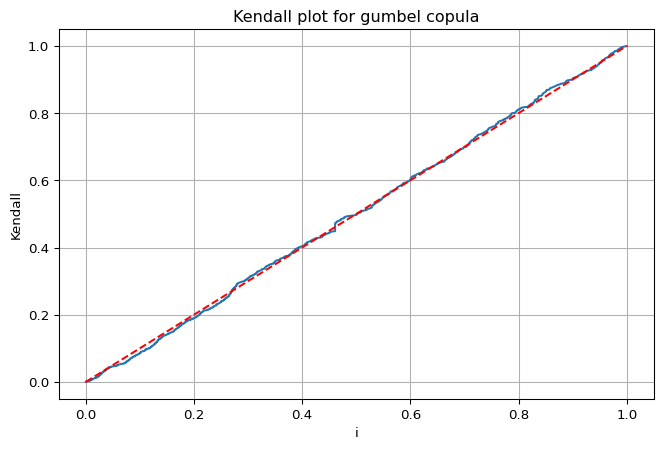

In [34]:
kendall_plot(u_obs,S,copula="gumbel",theta=theta)

#### III.4.4.d. Test d’adéquation

In [35]:
from pprint import pprint
result_gumbel = adequation_test(X, copula_type="gumbel") 
pprint(result_gumbel)

{'T_obs': array([0.03485682]),
 'copula_type': 'gumbel',
 'p_value': np.float64(0.98),
 'params': array([2.9939209])}

### III.4.4 Copule de frank

#### III.4.4.a. Estimation des paramètres de la copule frank

In [36]:
theta = fit_copula(u_obs, "frank")[0]

print("theta = ", theta)

theta =  10.0

#### III.4.4.b. Simulation de la copule de clayton

In [37]:
n = u_obs.shape[0]
_ = FrankCopula(theta= theta).rvs(n)
u_est = pseudo_observations(_)

#### III.4.4.c. Test d’ajustement

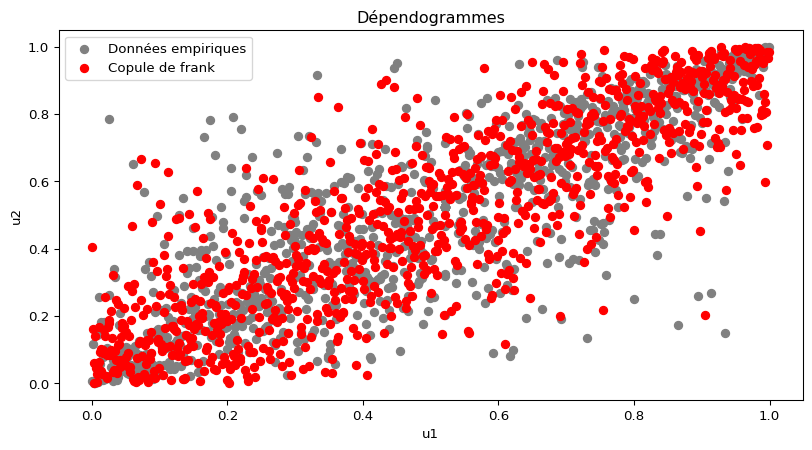

In [38]:
plt.figure(figsize=(10, 5))
plt.scatter(u_obs[:,0], u_obs[:,1], label = "Données empiriques", color = "grey")
plt.scatter(u_est[:,0], u_est[:,1], label = "Copule de frank", color = "red")
plt.title("Dépendogrammes")
plt.xlabel("u1")
plt.ylabel("u2")
plt.legend()
plt.grid(False)
plt.show()

(999,) (999,)

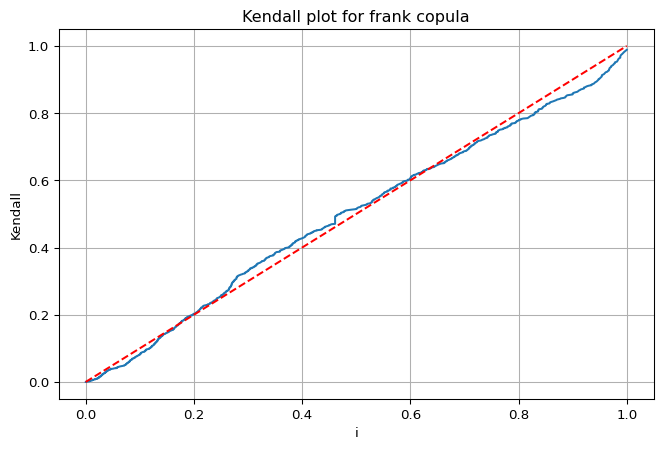

In [39]:
kendall_plot(u_obs,S,copula="frank",theta=theta)

#### III.4.4.d. Test d’adéquation

In [40]:
from pprint import pprint
result_frank = adequation_test(X, copula_type="frank") 
pprint(result_frank)

{'T_obs': array([0.12454173]),
 'copula_type': 'frank',
 'p_value': np.float64(0.488),
 'params': array([10.])}

### III.5. Résultats

In [41]:
dict_list = [result_gaussian, result_clayton, result_gumbel, result_frank]

# Convert to DataFrame
df = pd.DataFrame(dict_list)
df

# IV. Estimation de la Credit VaR

In [42]:
# Calcul de la credit var par monte carlo


def credit_var(params_R1,params_R2,lambda_1,lambda_2,EAD,params,S,tau,copula_type="gumbel",alpha=0.99):
    """
        Cette fonction est Var de niveau alpha qui estime la perte maximale sur l'horizon tau
        et retourne le quantile de niveau 99% pour dim=2.
    """

    copula = get_copula(copula_type, params)
    U = copula.rvs(S)
    a1,b1 = params_R1
    a2,b2 = params_R2

    # Générer des échantillons pour lgd_bnp et lgd_sg avec la loi Beta, vectorisée
    LGD1 = 1 - np.random.beta(a1, b1, S)
    LGD2 = 1 - np.random.beta(a2, b2, S)


    # Simuler tau_bnp et tau_sg en utilisant la fonction de répartition inverse de la loi exponentielle
    tau_bnp = stats.expon.ppf(U[:, 0], scale=1/lambda_1)
    tau_sg = stats.expon.ppf(U[:, 1], scale=1/lambda_2)

    # Calculer les pertes, vectorisée
    L1 = np.where(tau_bnp < tau, LGD1 * EAD, 0)
    L2 = np.where(tau_sg < tau, LGD2 * EAD, 0)

    # Somme des pertes
    L = L1 + L2

    # Calculer et retourner le quantile de niveau 99%
    return np.percentile(L, alpha * 100)

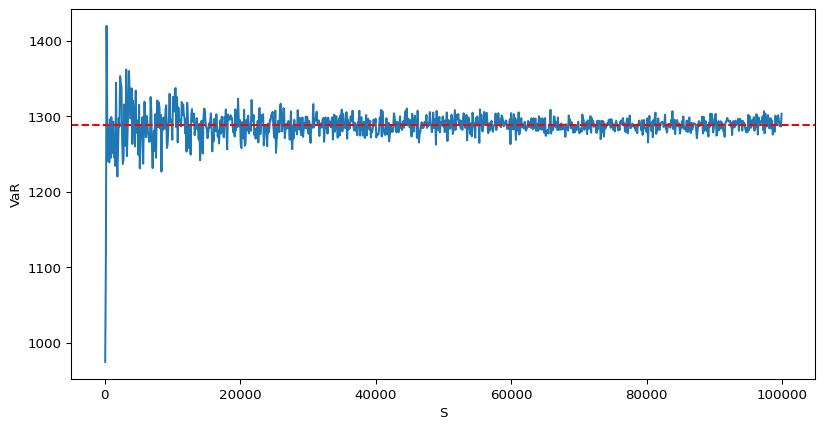

In [43]:
# Tracer la courbe de la VaR en fonction de S

S_values = np.arange(100, 100000, 100)
params = fit_copula(U, "gumbel")
EAD = 1000
tau = 4
def PD(T,spread,Recouvrement):
    lambda_ = spread / (1 - Recouvrement)
    PD = 1 - np.exp(-lambda_*T)
    return PD,lambda_

_,lambda_1 = PD(4,spread_4Y[0],tx_recouvrement)
_,lambda_2 = PD(4,spread_5Y[0],tx_recouvrement)

params_R1 = a_BNP,b_BNP
params_R2 = a_SG,b_SG
VaR_values = [credit_var(params_R1=params_R1,params_R2=params_R2, lambda_1=lambda_1, \
                         lambda_2=lambda_2, EAD=EAD, params=params, S=S, tau=tau) for S in S_values]

# Je veux tracer une droite horizontale pour la mediane de la VaR et mettre ça valeur sur l'axe des ordonnées
plt.figure(figsize=(10, 5))
plt.plot(S_values, VaR_values)
plt.axhline(np.mean(VaR_values), color="red", linestyle="--")
plt.xlabel("S")
plt.ylabel("VaR")
plt.grid(False)
plt.show()

In [44]:
np.mean(VaR_values)

np.float64(1288.01768323217)

In [45]:
S = 40000
credit_var(params_R1=params_R1,params_R2=params_R2, lambda_1=lambda_1, \
                         lambda_2=lambda_2, EAD=EAD, params=params, S=S, tau=tau)

np.float64(1294.6295817714831)